### 1. Tổng quan cơ sở toán

#### 1.1 Hàm sigmoid

Hàm sigmoid là hàm số dùng trong phân loại nhị phân, có công thức như sau:
$$g(x) = \frac{1}{1 + e^{-z}} $$

Bên dưới là độ thị của hàm sigmoid:

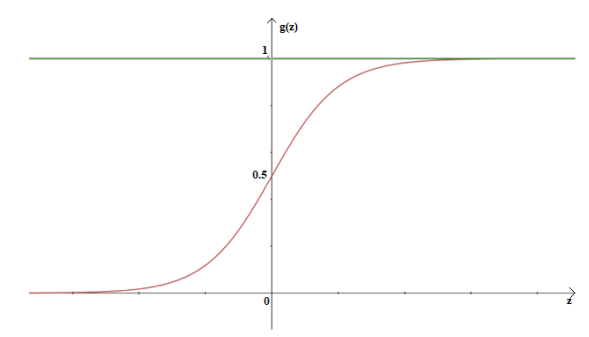

Hàm sigmoid dùng trong phân loại nhị phân vì:
- Đầu ra của hàm này nằm trong khoảng (0, 1), nên có thể biểu diễn đầu ra dưới dạng xác suất $P(y=1 | x, w)$
- Khi giá trị của đầu vào càng nhỏ (trong trường hợp này chính là khoảng cách đến đường phân chia - boundary) thì đầu ra sẽ tiến gần đến 0.5
- Khi giá trị của đầu vào càng lớn và âm (tức nằm về 1 phía nào đó) thì giá trị đầu ra sẽ tiến đến 0
- Khi giá trị của đầu vào càng lớn và dương (tức nằm về 1 phía nào đó) thì giá trị đầu ra sẽ tiến đến 1

#### 1.2 Mô hình Logistic Regression

Bài toán Logistic Regression là một bài toán phân loại nhị phân có thể được biểu diễn bằng đơn giản bằng ánh xạ sau:

$$ f: R^n → \{0, 1\} $$

Mô hình hồi quy logistic được biểu diễn như sau:

$$ \hat{y}= \frac{1}{1 + e^{- x^Tw}} $$

Ghi chú:
- $x^Tw$ là siêu phẳng phân chia tập dữ liệu thành 2 phần cho mục đích phân loại nhị phân (Đã được giải thích về bias ở trong phần Linear Regression trước đó)
- $g(x) = \frac{1}{1 + e^{-z}} $ là hàm sigmoid đã được trình bày ở trên

#### 1.3 Hàm mất mát

**Loss function** là hàm mất mát với từng điểm dữ liệu sẽ được biểu diễn như sau:

$$ L(\hat{y}, y) = -(ylog(\hat{y}) + (1-y)log(1-\hat{y})) $$

Với:
- $\hat{y}$ là giá trị dự đoán
- y là giá trị thực tế
- $log$ thực ra là $ln$ (Trong Machine learning người ta thường ký hiệu là $log$)

Hàm trên thực sự hợp lý vì khi giá trị thực tế vì:
- Khi $y=1$: hàm số trên được viết lại thành $L(\hat{y}, y) = -log(\hat{y})$. Khi giá trị dự đoán $\hat{y}$ tiến càng gần 1 thì giá trị của hàm mất mát sẽ tiến về 0 và ngược lại khi $\hat{y}$ càng tiến về 0 (tức càng xa giá trị đúng đắn) thì giá trị hàm mất mát sẽ rất lớn.
- Khi $y=0$: hàm số trên được viết lại thành $L(\hat{y}, y) = -log(1-\hat{y})$. Khi giá trị dự đoán $\hat{y}$ tiến càng gần 0 thì giá trị của hàm mất mát sẽ tiến về 0 và ngược lại khi $\hat{y}$ càng tiến về 1 (tức càng xa giá trị đúng đắn) thì giá trị hàm mất mát sẽ rất lớn.

**Cost function** là hàm mất mát cho toàn bộ tập dữ liệu, điều đó có nghĩa là ta phải tính giá trị trung bình:
$$ J(w) = - \frac{1}{m} \sum_{i=0}^m(y_ilog(\hat{y}_i) + (1-y_i)log(1-\hat{y}_i)) $$

Với:
- m là tổng số điểm dữ liệu
- $\hat{y}$ là giá trị mô hình dự đoán
- $y_i$ là giá trị thực tế

Cost function có đạo hàm cũng tương đối dễ tính chỉ cần áp dụng đạo hàm của hàm sigmoid:
$$ g^{'}(z)=g(z)(1-g(z))$$

Ta sẽ được kết quả sau:
$$ \nabla J(w)=\frac{1}{m}  X^T(Xw - y)$$





### 2. Cài đặt thuật toán

In [1]:
# Import một số thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [24]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, mini_batch_size=None, num_epochs=1000, epsilon=1e-8, 
                 optimizer='GD', beta=0.9, beta1=0.9, beta2=0.999, print_costs=False):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.print_costs = print_costs
        self.epsilon = epsilon
        self.optimizer = optimizer
        self.beta = beta # Dùng cho Momentum
        self.mini_batch_size = mini_batch_size
        self.w = None
        self.b = None
        self.v_dw = None # Dùng cho Momentum và Adam
        self.v_db = None # Dùng cho Momentum và Adam
        self.s_dw = None # Dùng cho Adam 
        self.s_db = None # Dùng cho Adam
        self.t = 0 # Dùng bias corrected trong adam
        self.beta1 = beta1 # Dùng cho Adam
        self.beta2 = beta2 # Dùng cho Adam
        self.costs = []

    def initialize_params(self, shape):
        self.w = np.zeros((shape, 1))
        self.b = 0
        if (self.optimizer == 'momentum'):
            print('momentum')
            self.v_dw = np.zeros(self.w.shape)
            self.v_db = 0
        elif (self.optimizer == 'adam'):
            print('adam')
            self.v_dw = np.zeros(self.w.shape)
            self.v_db = 0
            self.s_dw = np.zeros(self.w.shape)
            self.s_db = 0
    

    def y_hat(self, X):
        z = np.dot(X, self.w) + self.b
        y_hat = 1 / (1 + np.exp(-z))
        return y_hat

    def cost_function(self, X, y):
        m = X.shape[0]
        # Thêm epsilon để tránh trường hợp log(0)
        J = -1/m * np.sum(y * np.log(self.y_hat(X)+self.epsilon) + 
                          (1-y) * np.log(1 - self.y_hat(X) + self.epsilon))
        return J
    
    '''Gradient Descent'''
    def gradient(self, X, y):
        m = X.shape[0]
        y_pred = self.y_hat(X)
        dw = 1/m * np.dot(X.T, y_pred - y)
        db = 1/m * np.sum(y_pred - y)
        return dw, db

    def gradient_descent(self, X, y):
        for i in range(self.num_epochs):
            dw, db = self.gradient(X, y)
            cost = self.cost_function(X, y)
            self.w = self.w - self.learning_rate * dw
            self.b = self.b - self.learning_rate * db

            if self.print_costs and i % 100 == 0:
                print(f'Cost value after {i}: {cost}')
            self.costs.append(cost)
        


    '''Min-batch Gradient Desent'''
    def random_mini_batches(self, X, y, mini_batch_size = 64, seed = 0):
        """
        Creates a list of random minibatches from (X, y)
        
        Arguments:
        X -- input data, of shape (number of examples, input size)
        y -- true "label" vector of shape (number of examples, 1)
        mini_batch_size -- size of the mini-batches, integer
        
        Returns:
        mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
        """
        np.random.seed(seed)            
        m = X.shape[1]                  
        mini_batches = []

        # Step 1: Shuffle (X, Y)
        permutation = list(np.random.permutation(m))
        shuffled_X = X[permutation, :]
        shuffled_y = y[permutation, :]

        # Step 2 - Partition (shuffled_X, shuffled_Y).
        # Cases with a complete mini batch size only i.e each of 64 examples.
        num_complete_minibatches = math.floor(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
        for k in range(0, num_complete_minibatches):
            mini_batch_X = shuffled_X[k*mini_batch_size: (k+1) * mini_batch_size, :]
            mini_batch_Y = shuffled_y[k*mini_batch_size: (k+1) * mini_batch_size, :]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
        
        # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
        if m % mini_batch_size != 0:
            mini_batch_X = shuffled_X[num_complete_minibatches*mini_batch_size:, :]
            mini_batch_Y = shuffled_y[num_complete_minibatches*mini_batch_size:, :]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
        
        return mini_batches

    # Cập nhật trọng số với Gradient Descent truyền thống
    def update_parameters_with_GD(self, X, y):
        dw, db = self.gradient(X, y)
        self.w = self.w - self.learning_rate * dw
        self.b = self.b - self.learning_rate * db
    
    # Khởi tạo velocity cho momentum
    def initialize_velocity(self):
        self.v_dw = np.zeros(self.w.shape)
        self.v_db = 0
    
    # Cập nhật trọng số với Gradient Descent with Momentum
    def update_parameters_with_momentum(self, X, y):
        dw, db = self.gradient(X, y)
        self.v_dw = self.beta * self.v_dw + (1-self.beta) * dw
        self.v_db = self.beta * self.v_db + (1-self.beta) * db
        self.w -= self.learning_rate * self.v_dw
        self.b -= self.learning_rate * self.v_db
    
    # Cập nhật trọng số với adam
    def update_parameters_with_adam(self, X, y):
        dw, db = self.gradient(X, y)
        #Momentum
        self.v_dw = self.beta1 * self.v_dw + (1-self.beta1) * dw
        self.v_db = self.beta1 * self.v_db + (1-self.beta1) * db
        v_dw_corrected = self.v_dw / (1-self.beta1 ** self.t)
        v_db_corrected = self.v_db / (1-self.beta1 ** self.t)

        #RMSprop
        self.s_dw = self.beta2 * self.s_dw + (1-self.beta2) * dw**2
        self.s_db = self.beta2 * self.s_db + (1-self.beta2) * db**2
        s_dw_corrected = self.s_dw / (1-self.beta2 ** self.t)
        s_db_corrected = self.s_db / (1-self.beta2 ** self.t)

        self.w -= self.learning_rate * v_dw_corrected / (s_dw_corrected ** (1/2) + self.epsilon)
        self.b -= self.learning_rate * v_db_corrected / (s_db_corrected ** (1/2) + self.epsilon)

    def mini_batch_gradient_descent(self, X, y):
        m = X.shape[0]
        seed = 0
        # Khai báo dùng cho momentum và adam
        v_w = np.zeros(self.w.shape)
        v_b = 0
        for i in range(self.num_epochs):
            seed = seed + 1
            minibatches = self.random_mini_batches(X, y, self.mini_batch_size, seed)
            cost_total = 0

            for minibatch in minibatches:
                (minibatch_X, minibatch_y) = minibatch
                cost = self.cost_function(minibatch_X, minibatch_y)
                cost_total += cost

                if (self.optimizer == 'GD'):
                    self.update_parameters_with_GD(minibatch_X, minibatch_y)

                elif (self.optimizer == 'momentum'):
                    self.update_parameters_with_momentum(minibatch_X, minibatch_y)

                elif (self.optimizer == 'adam'):
                    self.t += 1 # Cập nhật bias correction
                    self.update_parameters_with_adam(minibatch_X, minibatch_y)
                    
            cost_avg = cost_total / m

            if self.print_costs and i % 100 == 0 and i > 0:
                print(f'Cost value after {i}: {cost_avg}')
                self.costs.append(cost_avg)
    
    def fit(self, X, y):
        y = y.reshape(-1, 1)
        self.initialize_params(X.shape[1])
        if (self.mini_batch_size == 1 or self.mini_batch_size == None):
            print("Batch Gradient Descent...")
            self.gradient_descent(X, y)
        else:
            if (self.mini_batch_size == X.shape[0]):
                print("Stochastic Gradient Descent...")
            else:
                print(f"Mini-batch Gradient Descent with {self.mini_batch_size} mini-batches ...")
            self.mini_batch_gradient_descent(X, y)

    def predict(self, X):
        y_pred = self.y_hat(X)
        return (y_pred > 0.5).astype(int)

    def plot_cost_history(self):
        if self.print_costs:
            plt.plot(range(self.num_epochs), self.costs)
            plt.xlabel("Epochs")
            plt.ylabel("Cost")
            plt.title("Cost History")
            plt.show()

### 3. Triển khai thuật toán

#### 3.1 Đọc tập dữ liệu

Em triển khai trên tập dữ liệu credit card vì nó đủ lớn và hạn chế bị lệch label

In [2]:
dataset = pd.read_csv('logistic_dataset.csv')
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values


#### 3.2 Tiền xử lý dữ liệu

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state=40)

In [5]:
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
X_train = scaler1.fit_transform(X_train)
X_test = scaler1.transform(X_test)

In [6]:
import numpy as np

class SVM:
    def __init__(self, learning_rate=0.01, num_epochs=1000, C=1.0, mini_batch_size=None,
                 epsilon=1e-8, optimizer='GD', beta=0.9, beta1=0.9, 
                 beta2=0.999, print_costs=False):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.C = C
        self.print_costs = print_costs
        self.w = None
        self.b = None

        self.mini_batch_size = mini_batch_size
        self.epsilon = epsilon
        self.optimizer = optimizer

        self.costs = [] # Dùng cho batch
        self.epochs_for_print = [] # Dùng cho batch

        self.all_costs = [] # Dùng cho mini-batch để trực quan hơn

        self.beta = beta # Dùng cho Momentum
        self.beta1 = beta1 # Dùng cho Adam
        self.beta2 = beta2 # Dùng cho Adam
        self.mini_batch_size = mini_batch_size
        self.w = None
        self.b = None
        self.v_dw = None # Dùng cho Momentum và Adam
        self.v_db = None # Dùng cho Momentum và Adam
        self.s_dw = None # Dùng cho Adam 
        self.s_db = None # Dùng cho Adam
        

    def initialize_params(self, shape):
        self.w = np.zeros((shape, 1))
        self.b = 0
        if (self.optimizer == 'momentum'):
            self.v_dw = np.zeros(self.w.shape)
            self.v_db = 0
        elif (self.optimizer == 'adam'):
            self.v_dw = np.zeros(self.w.shape)
            self.v_db = 0
            self.s_dw = np.zeros(self.w.shape)
            self.s_db = 0

    def margin(self, X, y):
        m = X.shape[0]
        margin = 1 - y * (np.dot(X, self.w) + self.b)
        margin = np.maximum(0, margin)
        return margin

    def cost_function(self, X, y):
        m = X.shape[0]
        margin = self.margin(X, y)
        regularization = 1 / 2 * np.dot(self.w.T, self.w)
        J = 1 / m * np.sum(margin) + self.C * regularization
        return J[0][0]

    def gradient(self, X, y):
        m = X.shape[0]
        margin = self.margin(X, y)
        loss = np.where(margin > 0, 1, 0)  # Loss for each data point
        loss = loss.reshape(-1, 1)

        dw = -(1 / m) * np.dot(X.T, loss * y) + self.C * self.w
        db = -(1 / m) * np.sum(loss * y)

        return dw, db

    '''Min-batch Gradient Desent'''
    def random_mini_batches(self, X, y, mini_batch_size = 64, seed = 0):
        """
        Input:
            - X: Dữ liệu đầu vào
            - y: Nhãn lớp 
            - mini_batch_size: số lượng example trong mỗi mini-batch
            - seed: giá trị để đảm bảo mỗi lần random sẽ khác biệt hoàn toàn

        Output:
            mini_batches: list của những phần tử (mini_batch_X, mini_batch_Y)
        """
        np.random.seed(seed)            
        m = X.shape[1]                  
        mini_batches = []

        # Bước 1: Xáo trộn
        permutation = list(np.random.permutation(m))
        shuffled_X = X[permutation, :]
        shuffled_y = y[permutation, :]

        # Bước 2: Phân chia X, y thành các mini-batch
        num_complete_minibatches = math.floor(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
        for k in range(0, num_complete_minibatches):
            mini_batch_X = shuffled_X[k*mini_batch_size: (k+1) * mini_batch_size, :]
            mini_batch_Y = shuffled_y[k*mini_batch_size: (k+1) * mini_batch_size, :]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
        
        # Xử lý mini-batch cuối cùng
        if m % mini_batch_size != 0:
            mini_batch_X = shuffled_X[num_complete_minibatches*mini_batch_size:, :]
            mini_batch_Y = shuffled_y[num_complete_minibatches*mini_batch_size:, :]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
        
        return mini_batches

    # Cập nhật trọng số với Gradient Descent truyền thống
    def update_parameters_with_GD(self, X, y):
        dw, db = self.gradient(X, y)
        self.w = self.w - self.learning_rate * dw
        self.b = self.b - self.learning_rate * db
    
    # Cập nhật trọng số với Gradient Descent with Momentum
    def update_parameters_with_momentum(self, X, y):
        dw, db = self.gradient(X, y)
        self.v_dw = self.beta * self.v_dw + (1-self.beta) * dw
        self.v_db = self.beta * self.v_db + (1-self.beta) * db
        self.w -= self.learning_rate * self.v_dw
        self.b -= self.learning_rate * self.v_db
    
    # Cập nhật trọng số với adam
    def update_parameters_with_adam(self, X, y):
        dw, db = self.gradient(X, y)
        #Momentum
        self.v_dw = self.beta1 * self.v_dw + (1-self.beta1) * dw
        self.v_db = self.beta1 * self.v_db + (1-self.beta1) * db

        #RMSprop
        self.s_dw = self.beta2 * self.s_dw + (1-self.beta2) * dw**2
        self.s_db = self.beta2 * self.s_db + (1-self.beta2) * db**2

        self.w -= self.learning_rate * self.v_dw / (self.s_dw ** (1/2) + self.epsilon)
        self.b -= self.learning_rate * self.v_db / (self.s_db ** (1/2) + self.epsilon)

    def mini_batch_gradient_descent(self, X, y):
        m = X.shape[0]
        seed = 0
        for i in range(self.num_epochs):
            seed = seed + 1
            minibatches = self.random_mini_batches(X, y, self.mini_batch_size, seed)
            cost_total = 0

            for minibatch in minibatches:
                (minibatch_X, minibatch_y) = minibatch
                cost = self.cost_function(minibatch_X, minibatch_y)
                
                cost_total += cost
                if (self.optimizer == 'GD'):
                    self.update_parameters_with_GD(minibatch_X, minibatch_y)

                elif (self.optimizer == 'momentum'):
                    self.update_parameters_with_momentum(minibatch_X, minibatch_y)

                elif (self.optimizer == 'adam'):
                    self.update_parameters_with_adam(minibatch_X, minibatch_y)
                    
            cost_avg = cost_total / m
            self.all_costs.append(cost_avg)
            
            if self.print_costs and i % 100 == 0 and i > 0:
                print(f'Cost value after {i}: {cost_avg}')
                self.costs.append(cost_avg)
                self.epochs_for_print.append(i)

    def fit(self, X, y):
        y = y.reshape(-1, 1)
        y = np.where(y == 1, 1, -1)
        self.initialize_params(X.shape[1])
        if (self.mini_batch_size == 1 or self.mini_batch_size == None):
            print("Batch Gradient Descent...")
            self.mini_batch_gradient_descent(X, y)
        else:
            if (self.mini_batch_size == X.shape[0]):
                print("Stochastic Gradient Descent...")
            else:
                print(f"Mini-batch Gradient Descent with {self.mini_batch_size} mini-batches ...")
            self.mini_batch_gradient_descent(X, y)

    def predict(self, X):
        y_pred = np.dot(X, self.w) + self.b
        y_pred = np.sign(y_pred)
        y_pred = np.where(y_pred == 1, 1, 0)
        return y_pred

    def plot_cost_history(self):
        if self.print_costs:
            import matplotlib.pyplot as plt
            if self.mini_batch_size > 1:
                plt.plot(range(self.num_epochs), self.all_costs)
                plt.xlabel('Iterations')
            else:
                plt.plot(self.epochs_for_print, self.costs)
                plt.xlabel("Epochs")
            plt.ylabel("Cost")
            plt.title("Cost History")
            plt.show()


Mini-batch Gradient Descent with 64 mini-batches ...
Cost value after 100: 4.096786342396006e-08
Cost value after 200: 1.098681739701979e-08
Cost value after 300: 6.4993810430712265e-09
Cost value after 400: 5.8663863647414025e-09
Cost value after 500: 6.089308053473683e-09
Cost value after 600: 5.4756279898426e-09
Cost value after 700: 6.110876264645224e-09
Cost value after 800: 5.7437391098486436e-09
Cost value after 900: 5.98529725608243e-09


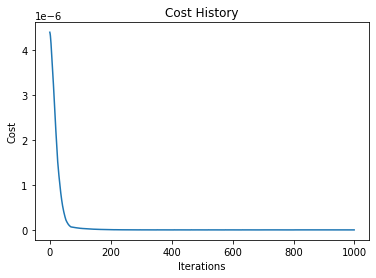

Accuracy: 0.9992626663389628


In [11]:
svm_gd = SVM(learning_rate=0.03, num_epochs=1000, C=0.3,
          mini_batch_size=64, print_costs=True,
          optimizer='momentum')
svm_gd.fit(X_train, y_train)
svm_gd.plot_cost_history()
from sklearn.metrics import accuracy_score
y_pred1 = svm_gd.predict(X_test)
accuracy = accuracy_score(y_test, y_pred1)
print("Accuracy:", accuracy)

In [33]:
logistic_regression = LogisticRegression(learning_rate=0.03, num_epochs=100, 
                                         mini_batch_size=64, optimizer='adam', 
                                         print_costs=True)
logistic_regression.fit(X_train, y_train)

adam
Mini-batch Gradient Descent with 64 mini-batches ...


In [34]:
y_pred = logistic_regression.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("accuracy: ", accuracy)

accuracy:  0.8025350233488993


In [9]:
new_1_column = np.ones((X_train.shape[0], 1), dtype=int)
X_train_scratch = np.hstack((new_1_column, X_train))
print("Kiểm tra X_train_scratch: \n", X_train_scratch[:5])

Kiểm tra X_train_scratch: 
 [[  1.          -0.50477201   0.61522485   0.09009756   0.39918516
    0.39793312  -0.43465629  -0.60619949  -0.07487182  -0.0244909
   -0.09968893   0.11734731   1.50159642   0.7091484   -0.59534756
    0.63106425   0.43946149   0.54387928  -0.65475815  -0.02110364
    0.12211058  -0.18363096  -0.27630964  -0.9075095    0.25627482
    0.84092951   0.25706794   0.13967233  -0.09384072   0.02757396
   -0.34998492]
 [  1.           0.97113071   0.10935485   0.59750826  -0.49657022
   -0.78794695   1.00070866  -0.86703373   1.33728195  -0.37422486
   -0.84440453  -0.48423434   0.72558901   1.17469485   1.08098667
    0.63861028  -0.97394613  -0.42841776  -0.9827763    0.05679476
    0.41236923  -0.13396273   0.36208642   1.20303957  -0.63801766
   -0.52164205   0.47839895   0.34420379  -0.01699563   0.01515803
   -0.34638764]
 [  1.          -1.81008666  -2.36017966   1.02700412  -2.06027337
    3.06059177  -1.37327549  -0.74662569  -3.78219219   0.39567558
   

In [10]:
new_1_column = np.ones((X_test.shape[0], 1), dtype=int)
X_test_scratch = np.hstack((new_1_column, X_test))
X_test_scratch[:5]
print("Kiểm tra X_test_scratch: \n", X_test_scratch[:5])

Kiểm tra X_test_scratch: 
 [[ 1.00000000e+00 -9.04600964e-01  5.80349176e-01 -4.02966758e-01
   1.71366579e-01  3.33829598e-01 -6.86283443e-01 -2.27755004e-01
  -3.76398676e-01  5.31720555e-02 -8.81060569e-01  9.70819381e-01
   4.09357128e-01 -6.25120820e-01 -1.73330206e+00  7.89280265e-01
   4.18900085e-01 -1.02973845e+00 -5.72357604e-01  2.55459403e+00
  -1.02794532e+00 -6.09450460e-01 -3.61847487e-01 -8.25489504e-01
  -1.70124764e-01 -1.57594391e-01  7.84623123e-01 -6.78537116e-01
   3.23018766e-02  8.37539510e-02  4.62004721e-02]
 [ 1.00000000e+00 -4.48246283e-01 -5.77511242e-01  4.92808846e-01
   5.90732525e-01 -3.89164545e-01  1.34407768e+00  3.20440260e+00
  -4.69365357e-01  1.10801148e+00  1.07616938e-01 -4.62131735e-01
  -7.38683015e-01 -2.11552220e-02 -1.04237617e-01 -2.85286024e-01
   2.53105720e-01  3.26235073e-01 -7.43040530e-01  6.72684338e-01
   5.16723463e-01  4.33772090e-03 -5.82181469e-02 -2.42065147e-01
  -5.42019002e-01  1.64981238e+00  8.69094150e-01 -8.54768601e-0

In [11]:
y_train_scratch = y_train.reshape(-1, 1)

#### 3.3 Huấn luyện mô hình Logistic Regression

In [13]:
w_optimal, costs = logistic_regression(X_train_scratch, y_train_scratch,
                                     iterations=2000, learning_rate=0.03,
                                     print_costs=True)

Cost value after 0:  0.6931471805599451
Cost value after 100:  0.2947150730295793
Cost value after 200:  0.17350538887950115
Cost value after 300:  0.12066387995407653
Cost value after 400:  0.0920200156885429
Cost value after 500:  0.0742952644061327
Cost value after 600:  0.06233061990381779
Cost value after 700:  0.053746304891999365
Cost value after 800:  0.04730413651331407
Cost value after 900:  0.04230025444322232
Cost value after 1000:  0.03830651691353622
Cost value after 1100:  0.03504821927203011
Cost value after 1200:  0.03234133867036766
Cost value after 1300:  0.030058138230021958
Cost value after 1400:  0.028107269188783483
Cost value after 1500:  0.02642172901509596
Cost value after 1600:  0.02495128971345886
Cost value after 1700:  0.0236575779339151
Cost value after 1800:  0.022510785703103928
Cost value after 1900:  0.021487415706771654


In [14]:
print("Vector trọng số: \n", w_optimal)

Vector trọng số: 
 [[-4.01538473e+00]
 [-1.05327874e-03]
 [-2.86956158e-02]
 [ 3.16517431e-02]
 [-6.96871859e-02]
 [ 7.28591890e-02]
 [-1.37158613e-02]
 [-1.86655798e-02]
 [-5.81554234e-02]
 [-1.61153263e-02]
 [-4.52379947e-02]
 [-8.91799221e-02]
 [ 6.81410483e-02]
 [-1.10828214e-01]
 [-7.05927771e-03]
 [-1.55030804e-01]
 [-1.70214199e-03]
 [-7.04469008e-02]
 [-1.02680357e-01]
 [-2.94324350e-02]
 [ 8.58072383e-03]
 [ 3.75147872e-03]
 [ 1.71608624e-02]
 [ 3.63771619e-03]
 [-7.10500264e-04]
 [-5.84473743e-03]
 [-1.65487980e-03]
 [ 4.74300374e-03]
 [ 3.09478129e-03]
 [ 1.88106917e-03]
 [ 6.73271343e-03]]


#### 3.4 Đánh giá mô hình

In [15]:
y_pred_scratch = predict(X_test_scratch, w_optimal).reshape(-1, 1)

In [18]:
from sklearn.metrics import accuracy_score
accuracy_scratch = accuracy_score(y_test, y_pred_scratch)
print("accuracy: ", accuracy_scratch)

accuracy:  0.9992451107756047


### 4 Triển khai thử trên thư viện Sklearn

In [17]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [19]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Độ chính xác của mô hình: {:.2f}%".format(accuracy * 100))

Độ chính xác của mô hình: 99.93%


### 5. Kết luận

So sánh độ chính xác của mô hình tự triển khai và thư viện thì khá tương đồng, do đó mô hình tự triển khai khả năng cao là chính xác. Các tập dữ liệu của thầy có vẻ như là tập dữ liệu mẫu cho logistic regression nên độ chính xác đạt được rất cao.